In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
"""
In order to run the code as is, you will need scipy, pandas and tqdm installed 
(although tqdm is only needed for the progress bar, and pandas is only for the autocorrelation function)
All of these can be installed (on linux) from the command interface using 'pip'
""" 

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from gibbsrank import gibbs_sample
from eprank import eprank
import pandas
from cw2 import sorted_barplot

We first need to load the data, stored in "tennis_data.mat". The data consists of an array, $W$ containing the names of each player, and an array, G, containing the results of all of the matches in the season. 

In [3]:
# set seed for reproducibility
np.random.seed(0)
# load data
data = sio.loadmat('tennis_data.mat')
# Array containing the names of each player
W = data['W']
# loop over array to format more nicely
for i, player in enumerate(W):
    W[i] = player[0]
# Array of size num_games x 2. The first entry in each row is the winner of game i, the second is the loser
G = data['G'] - 1
# Number of players
M = W.shape[0]
# Number of Games
N = G.shape[0]

# Gibbs sampling (This may take a minute)

In [62]:
# number of iterations
num_iters = 1100
# perform gibbs sampling, skill samples is an num_players x num_samples array
skill_samples = gibbs_sample(G, M, num_iters)
print(skill_samples.shape)

100%|██████████| 1100/1100 [00:32<00:00, 34.09it/s]

(107, 1100)


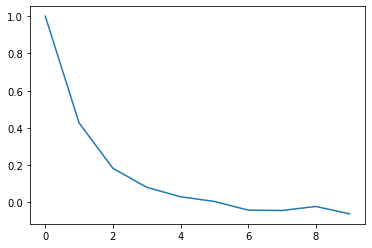

In [63]:
# Code for plotting the autocorrelation function for player p
p = 5

autocor = np.zeros(10)
for i in range(10):
    autocor[i]=pandas.Series.autocorr(pandas.Series(skill_samples[p,:]),lag=i)
plt.plot(autocor)

# EP ranking

In [64]:
num_iters = 100
# run message passing algorithm, returns mean and precision for each player
mean_player_skills, precision_player_skills = eprank(G, M, num_iters)

# Assignment questions

In [65]:
def plot_autocorr(player_id, total_lag):
    autocor = np.zeros(total_lag)
    for i in range(total_lag):
        autocor[i]=pandas.Series.autocorr(pandas.Series(skill_samples[player_id,:]),lag=i)
    plt.plot(autocor)

### Question a)

Plot some of the sampled player skills as a function of the Gibbs iteration

In [66]:
color_list = ['blue', 'magenta', 'green', 'red']

def plot_sampled_skills(skill_samples, player_list, add_mean_std=False):
    xrange = range(skill_samples.shape[1])
    nplayers = len(player_list)
    fig, axes = plt.subplots(nrows=nplayers, ncols=1)
    fig.set_figheight(10)
    fig.set_figwidth(14)
    fig.subplots_adjust(hspace=.5)
    plt.xlabel("Gibbs iteration", fontweight="bold")
    axes[0].set_title("Players sampled skills vs Gibbs iteration", fontweight="bold", fontsize=18)

    for i in range(nplayers):
        axes[i].plot(xrange, skill_samples[i], color=color_list[i%len(color_list)])
        axes[i].set_xlim(0, len(xrange))
        if add_mean_std:
            skill_mean = np.array([np.mean(skill_samples[i])]*len(xrange))
            skill_std = np.array([np.std(skill_samples[i])]*len(xrange))
            axes[i].fill_between(xrange, skill_mean-2*skill_std, skill_mean+2*skill_std, alpha=0.5)
            axes[i].plot(xrange, skill_mean, '-')
        
        axes 
        axes[i].set_ylabel("Player "+str(player_list[i])+" skills", fontweight="bold")

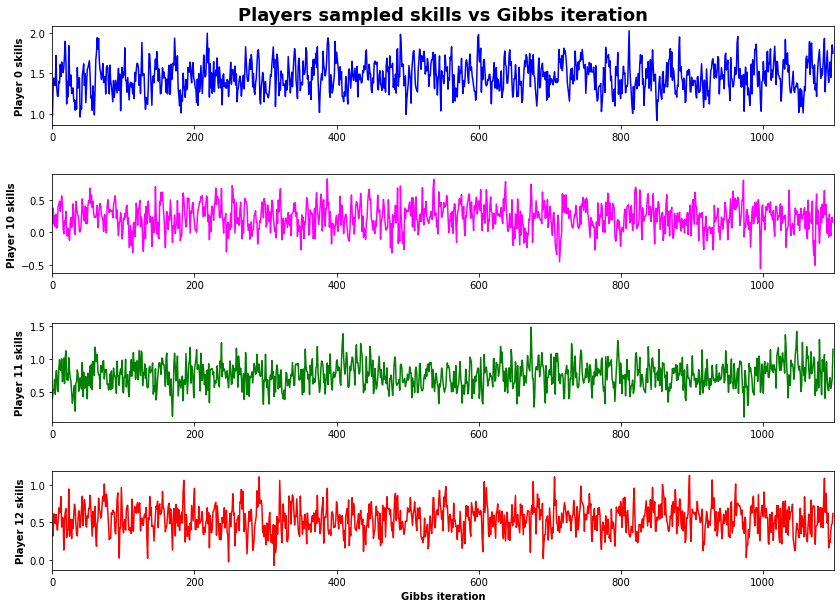

In [71]:
plot_sampled_skills(skill_samples, [0, 10, 11, 12])

What are the burn in and auto-correlation times and how long would you run the Gibbs sampler to get reliable results?

In [10]:
def plot_autocorr(player_id, total_lag):
    autocor = np.zeros(total_lag)
    for i in range(total_lag):
        autocor[i]=pandas.Series.autocorr(pandas.Series(skill_samples[player_id,:]),lag=i)
    plt.plot(autocor)
    plt.title("Auto-correlation vs Lag of player "+str(player_id), fontweight='bold')
    plt.ylabel("Auto-correlation")
    plt.xlabel("Lag")

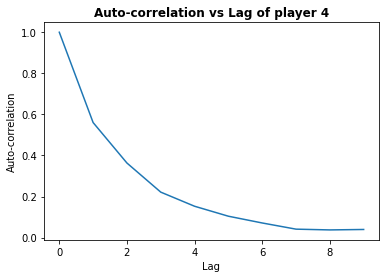

In [11]:
plot_autocorr(player_id=4, total_lag=10)

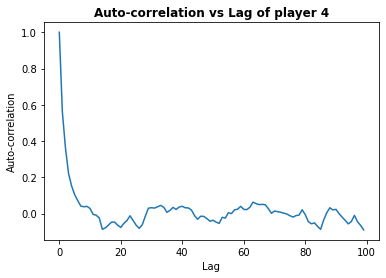

In [12]:
plot_autocorr(player_id=4, total_lag=100)

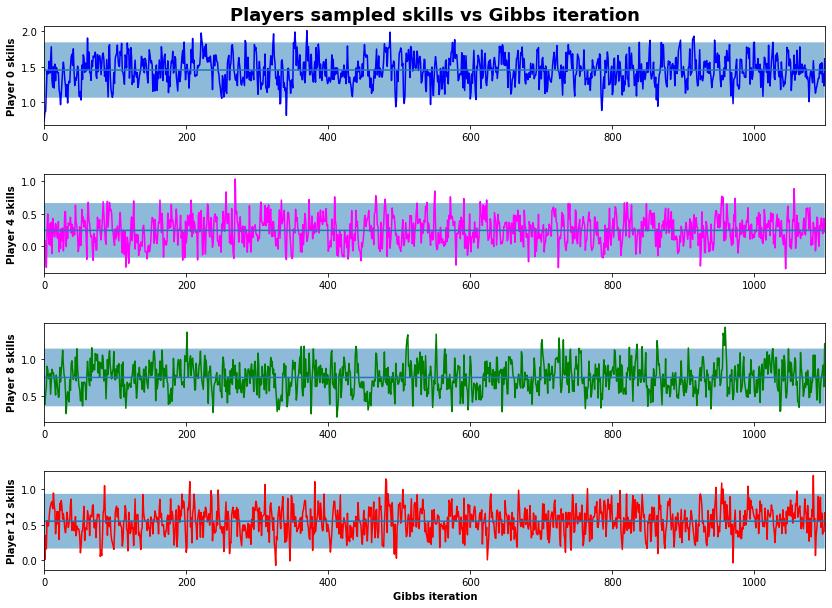

In [13]:
plot_sampled_skills(skill_samples, [0, 4, 8, 12], add_mean_std=True)

#### Burn-in and thinning
- Burn-in of 20-30 samples
- Thinning: we keep every 10th sample. 

In [72]:
def exec_burn_in(skill_samples, burn_in_size):
    return skill_samples[:,burn_in_size:]

def exec_thinning(skill_samples, thinning_size):
    thinning = (np.array(range(skill_samples.shape[1])) % thinning_size) == 0
    return skill_samples[:,thinning]

In [73]:
skill_samples = exec_burn_in(skill_samples, burn_in_size=30)
skill_samples.shape

(107, 1070)

In [74]:
skill_samples = exec_thinning(skill_samples, thinning_size=2)
skill_samples.shape

(107, 535)

### Question b)

In [75]:
num_iters = 100
# run message passing algorithm, returns mean and precision for each player
mean_player_skills, precision_player_skills, all_mean_skills, all_precision_skills  = eprank(G, M, num_iters, ret_all_iters=True)

In [165]:
def calculate_convergence_point(arr, tol, ntimes=10):
    t = 0
    for i in range(1, len(arr)):
        if abs(arr[i] - arr[i-1]) <= tol:
            t += 1
            if t == ntimes:
                return i
    return len(arr)


def plot_convergence_MP(player_ids, all_mean_skills, all_precision_skills):
    nplayers = len(player_ids)
    fig, axes = plt.subplots(nrows=nplayers, ncols=2)
    fig.set_figheight(3*nplayers)
    fig.set_figwidth(15)
    fig.subplots_adjust(hspace=.3)
    axes[-1][0].set_xlabel("EP iteration", fontweight="bold")
    axes[-1][1].set_xlabel("EP iteration", fontweight="bold")
    axes[0][0].set_title("Player mean skill vs EP iteration", fontweight="bold", fontsize=14)
    axes[0][1].set_title("Player precision skill vs EP iteration", fontweight="bold", fontsize=14)

    xrange = range(all_mean_skills.shape[1])

    for i in range(nplayers):
        axes[i][0].plot(xrange, all_mean_skills[player_ids[i]], label='mean')
        axes[i][1].plot(xrange, all_precision_skills[player_ids[i]], label='precision')
        axes[i][0].set_xlim(-1, len(xrange))
        axes[i][1].set_xlim(-1, len(xrange))
        axes[i][0].set_ylabel("Player "+str(player_ids[i]), fontweight="bold")

        index_convg_mean = calculate_convergence_point(all_mean_skills[player_ids[i]], 10**-3, ntimes=10)
        axes[i][0].plot(index_convg_mean, all_mean_skills[player_ids[i]][index_convg_mean], '-ro')
        index_convg_prec = calculate_convergence_point(all_precision_skills[player_ids[i]], 10**-3, ntimes=10)
        axes[i][1].plot(index_convg_prec, all_precision_skills[player_ids[i]][index_convg_prec], '-ro')

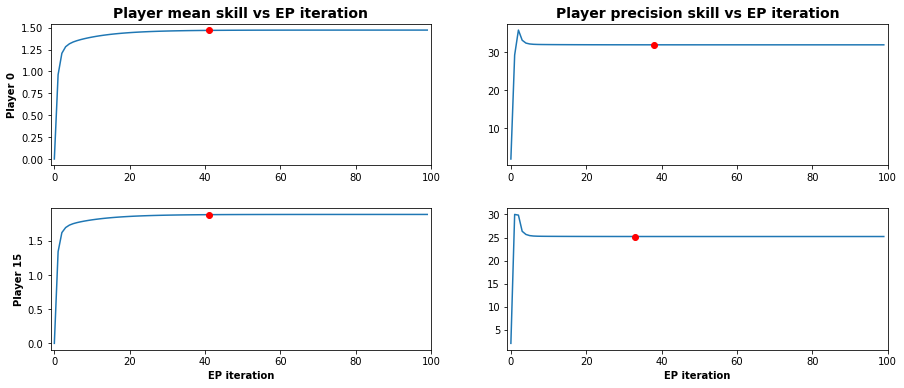

In [167]:
plot_convergence_MP([0, 15], all_mean_skills, all_precision_skills)

### Question c) Message passing algorithm

From lecture notes:
1) Novak Djokovic: ID = 15
2) Rafael Nadal: ID = 0
3) Roger Federer: ID = 4
4) Andy Murray: ID = 10

In [77]:
from tabulate import tabulate
import scipy
import math

In [78]:
def table_skill_probs_EP(player_list, player_names, mean_skills, precision_skills):
    nplayers = len(player_list)

    table = []
    for i in range(nplayers):
        row = [player_names[player_list[i]][0]] # appending player name
        for j in range(nplayers):
            if i != j:
                mu = mean_skills[player_list[i]] - mean_skills[player_list[j]]
                var = 1/precision_skills[player_list[i]] + 1/precision_skills[player_list[j]]
                prob = 1 - scipy.stats.norm.cdf(0, mu, np.sqrt(var))
                row.append(round(prob,4))
            else:
                row.append("---")
        table.append(row)
    
    headers = [" "]
    for i in range(nplayers):
        headers.append(player_names[player_list[i]][0])

    return tabulate(table, headers=headers, tablefmt="fancy_grid")


In [79]:
player_ids = [15, 0, 4, 10] # Djokovik, Nadal, Federer, Murray
table = table_skill_probs_EP(player_ids, W, mean_player_skills, precision_player_skills)
print(table)

╒════════════════╤══════════════════╤════════════════╤═════════════════╤═══════════════╕
│                │ Novak-Djokovic   │ Rafael-Nadal   │ Roger-Federer   │ Andy-Murray   │
╞════════════════╪══════════════════╪════════════════╪═════════════════╪═══════════════╡
│ Novak-Djokovic │ ---              │ 0.9398         │ 0.9089          │ 0.9853        │
├────────────────┼──────────────────┼────────────────┼─────────────────┼───────────────┤
│ Rafael-Nadal   │ 0.0602           │ ---            │ 0.4272          │ 0.7665        │
├────────────────┼──────────────────┼────────────────┼─────────────────┼───────────────┤
│ Roger-Federer  │ 0.0911           │ 0.5728         │ ---             │ 0.8108        │
├────────────────┼──────────────────┼────────────────┼─────────────────┼───────────────┤
│ Andy-Murray    │ 0.0147           │ 0.2335         │ 0.1892          │ ---           │
╘════════════════╧══════════════════╧════════════════╧═════════════════╧═══════════════╛


In [80]:
def table_winning_probs_EP(player_list, player_names, mean_skills, precision_skills):
    nplayers = len(player_list)

    table = []
    for i in range(nplayers):
        row = [player_names[player_list[i]][0]] # appending player name
        for j in range(nplayers):
            if i != j:
                mu = mean_skills[player_list[i]] - mean_skills[player_list[j]]
                var = 1/precision_skills[player_list[i]] + 1/precision_skills[player_list[j]]
                x = mu/np.sqrt(1+var)
                prob = scipy.stats.norm.cdf(x, 0, 1)
                row.append(round(prob,4))
            else:
                row.append("---")
        table.append(row)
    
    headers = [" "]
    for i in range(nplayers):
        headers.append(player_names[player_list[i]][0])

    return tabulate(table, headers=headers, tablefmt="fancy_grid")

In [81]:
player_ids = [15, 0, 4, 10] # Djokovik, Nadal, Federer, Murray
table = table_winning_probs_EP(player_ids, W, mean_player_skills, precision_player_skills)
print(table)

╒════════════════╤══════════════════╤════════════════╤═════════════════╤═══════════════╕
│                │ Novak-Djokovic   │ Rafael-Nadal   │ Roger-Federer   │ Andy-Murray   │
╞════════════════╪══════════════════╪════════════════╪═════════════════╪═══════════════╡
│ Novak-Djokovic │ ---              │ 0.6554         │ 0.638           │ 0.7198        │
├────────────────┼──────────────────┼────────────────┼─────────────────┼───────────────┤
│ Rafael-Nadal   │ 0.3446           │ ---            │ 0.4816          │ 0.5731        │
├────────────────┼──────────────────┼────────────────┼─────────────────┼───────────────┤
│ Roger-Federer  │ 0.362            │ 0.5184         │ ---             │ 0.5909        │
├────────────────┼──────────────────┼────────────────┼─────────────────┼───────────────┤
│ Andy-Murray    │ 0.2802           │ 0.4269         │ 0.4091          │ ---           │
╘════════════════╧══════════════════╧════════════════╧═════════════════╧═══════════════╛


### Question d) Gibbs sampling

#### d.1 Approximating marginal skills by Gaussians

In [82]:
def table_skill_marginal_probs_GS(player_ids, player_names, skill_samples):
    nplayers = len(player_ids)

    means = np.mean(skill_samples[player_ids,:], axis=1)
    vars = np.var(skill_samples[player_ids,:], axis=1)

    table = []
    for i in range(nplayers):
        row = [player_names[player_ids[i]][0]] # appending player name
        for j in range(nplayers):
            if i != j:
                prob = 1 - scipy.stats.norm.cdf(0, means[i]-means[j], np.sqrt(vars[i]+vars[j]))
                row.append(round(prob,4))
            else:
                row.append("---")
        table.append(row)
    
    headers = [" "]
    for i in range(nplayers):
        headers.append(player_names[player_ids[i]][0])

    return tabulate(table, headers=headers, tablefmt="fancy_grid")

In [92]:
player_ids = [15, 0, 4, 10] # Djokovik, Nadal, Federer, Murray
table = table_skill_marginal_probs_GS(player_ids, W, skill_samples)
print(table)

╒════════════════╤══════════════════╤════════════════╤═════════════════╤═══════════════╕
│                │ Novak-Djokovic   │ Rafael-Nadal   │ Roger-Federer   │ Andy-Murray   │
╞════════════════╪══════════════════╪════════════════╪═════════════════╪═══════════════╡
│ Novak-Djokovic │ ---              │ 0.9192         │ 0.8672          │ 0.9753        │
├────────────────┼──────────────────┼────────────────┼─────────────────┼───────────────┤
│ Rafael-Nadal   │ 0.0808           │ ---            │ 0.4073          │ 0.7333        │
├────────────────┼──────────────────┼────────────────┼─────────────────┼───────────────┤
│ Roger-Federer  │ 0.1328           │ 0.5927         │ ---             │ 0.7948        │
├────────────────┼──────────────────┼────────────────┼─────────────────┼───────────────┤
│ Andy-Murray    │ 0.0247           │ 0.2667         │ 0.2052          │ ---           │
╘════════════════╧══════════════════╧════════════════╧═════════════════╧═══════════════╛


#### d.2 Approximating joint skills by Gaussians

In [126]:
def integrand_2dgauss(x, y, mean, cov):
    return scipy.stats.multivariate_normal.pdf([x,y], np.array(mean), cov)

def table_skill_joint_probs_GS(player_ids, player_names, skill_samples):
    nplayers = len(player_ids)
    
    table = []
    for i in range(nplayers):
        row = [player_names[player_ids[i]][0]] # appending player name
        for j in range(nplayers):
            if i != j:
                mean_1 = np.mean(skill_samples[player_ids[i],:], axis=0)
                mean_2 = np.mean(skill_samples[player_ids[j],:], axis=0)
                Sigma_cov = np.cov(skill_samples[player_ids[i],:], skill_samples[player_ids[j],:])

                int_result, abs_error = scipy.integrate.dblquad(integrand_2dgauss,
                                                                -np.inf, np.inf, -np.inf, lambda x: x,
                                                                args=([mean_1,mean_2], Sigma_cov)
                                                                )

                prob_winning_p1 = 1 - int_result
                row.append(round(prob_winning_p1, 4))
            else:
                row.append("---")
        table.append(row)
    
    headers = [" "]
    for i in range(nplayers):
        headers.append(player_names[player_ids[i]][0])

    return tabulate(table, headers=headers, tablefmt="fancy_grid")
    

In [128]:
player_ids = [15, 0, 4, 10] # Djokovik, Nadal, Federer, Murray
table = table_skill_joint_probs_GS(player_ids, W, skill_samples)
print(table)

╒════════════════╤══════════════════╤════════════════╤═════════════════╤═══════════════╕
│                │ Novak-Djokovic   │ Rafael-Nadal   │ Roger-Federer   │ Andy-Murray   │
╞════════════════╪══════════════════╪════════════════╪═════════════════╪═══════════════╡
│ Novak-Djokovic │ ---              │ 0.9401         │ 0.8834          │ 0.981         │
├────────────────┼──────────────────┼────────────────┼─────────────────┼───────────────┤
│ Rafael-Nadal   │ 0.0599           │ ---            │ 0.3955          │ 0.7542        │
├────────────────┼──────────────────┼────────────────┼─────────────────┼───────────────┤
│ Roger-Federer  │ 0.1166           │ 0.6045         │ ---             │ 0.8082        │
├────────────────┼──────────────────┼────────────────┼─────────────────┼───────────────┤
│ Andy-Murray    │ 0.019            │ 0.2458         │ 0.1918          │ ---           │
╘════════════════╧══════════════════╧════════════════╧═════════════════╧═══════════════╛


#### d.3 Approximating skills directly from the data

In [84]:
def table_skill_sample_probs_GS(player_ids, player_names, skill_samples):
    nplayers = len(player_ids)

    table = []
    for i in range(nplayers):
        row = [player_names[player_ids[i]][0]] # appending player name
        for j in range(nplayers):
            if i != j:
                prob = np.mean(skill_samples[player_ids[i],:] > skill_samples[player_ids[j],:])
                row.append(round(prob,4))
            else:
                row.append("---")
        table.append(row)
    
    headers = [" "]
    for i in range(nplayers):
        headers.append(player_names[player_ids[i]][0])

    return tabulate(table, headers=headers, tablefmt="fancy_grid")

In [85]:
player_ids = [15, 0, 4, 10] # Djokovik, Nadal, Federer, Murray
table = table_skill_sample_probs_GS(player_ids, W, skill_samples)
print(table)

╒════════════════╤══════════════════╤════════════════╤═════════════════╤═══════════════╕
│                │ Novak-Djokovic   │ Rafael-Nadal   │ Roger-Federer   │ Andy-Murray   │
╞════════════════╪══════════════════╪════════════════╪═════════════════╪═══════════════╡
│ Novak-Djokovic │ ---              │ 0.9383         │ 0.8879          │ 0.9813        │
├────────────────┼──────────────────┼────────────────┼─────────────────┼───────────────┤
│ Rafael-Nadal   │ 0.0617           │ ---            │ 0.385           │ 0.7514        │
├────────────────┼──────────────────┼────────────────┼─────────────────┼───────────────┤
│ Roger-Federer  │ 0.1121           │ 0.615          │ ---             │ 0.8243        │
├────────────────┼──────────────────┼────────────────┼─────────────────┼───────────────┤
│ Andy-Murray    │ 0.0187           │ 0.2486         │ 0.1757          │ ---           │
╘════════════════╧══════════════════╧════════════════╧═════════════════╧═══════════════╛


### Question e)

#### e.1 Empirical game outcome averages

In [86]:
empirical_averages = np.zeros(M)

for p in range(M):
    # empirical average of a player = no. games won / no. games played
    empirical_averages[p] = sum(G[:,0]==p)/(sum(G[:,0]==p)+sum(G[:,1]==p))

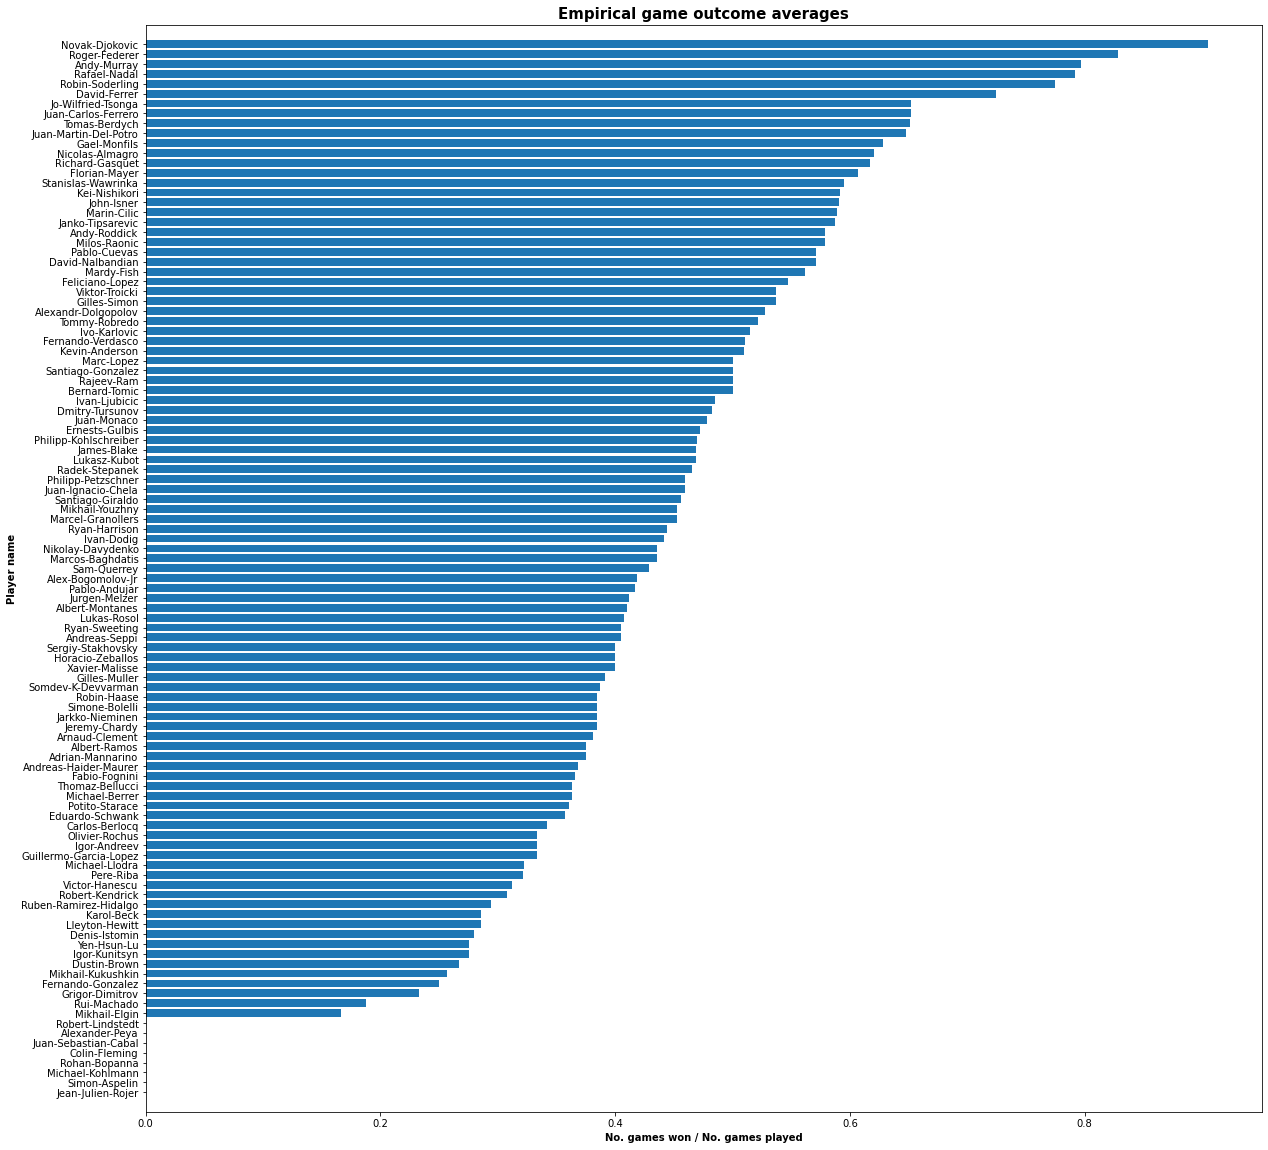

In [87]:
sorted_barplot(empirical_averages, W,
               title="Empirical game outcome averages",
               xlabel="No. games won / No. games played",
               ylabel="Player name")

#### e.2 Predictions based on Gibbs sampling

In [88]:
GS_predictions = np.zeros(M)

means = np.mean(skill_samples, axis=1)
vars = np.var(skill_samples, axis=1)

for i in range(M):
    avg_prob = 0.0
    for j in range(M):
        if i!=j:
            avg_prob += 1 - scipy.stats.norm.cdf(0, means[i]-means[j], np.sqrt(1+vars[i]+vars[j]))
    GS_predictions[i] = avg_prob/(M-1) # average probability of player i winning a game

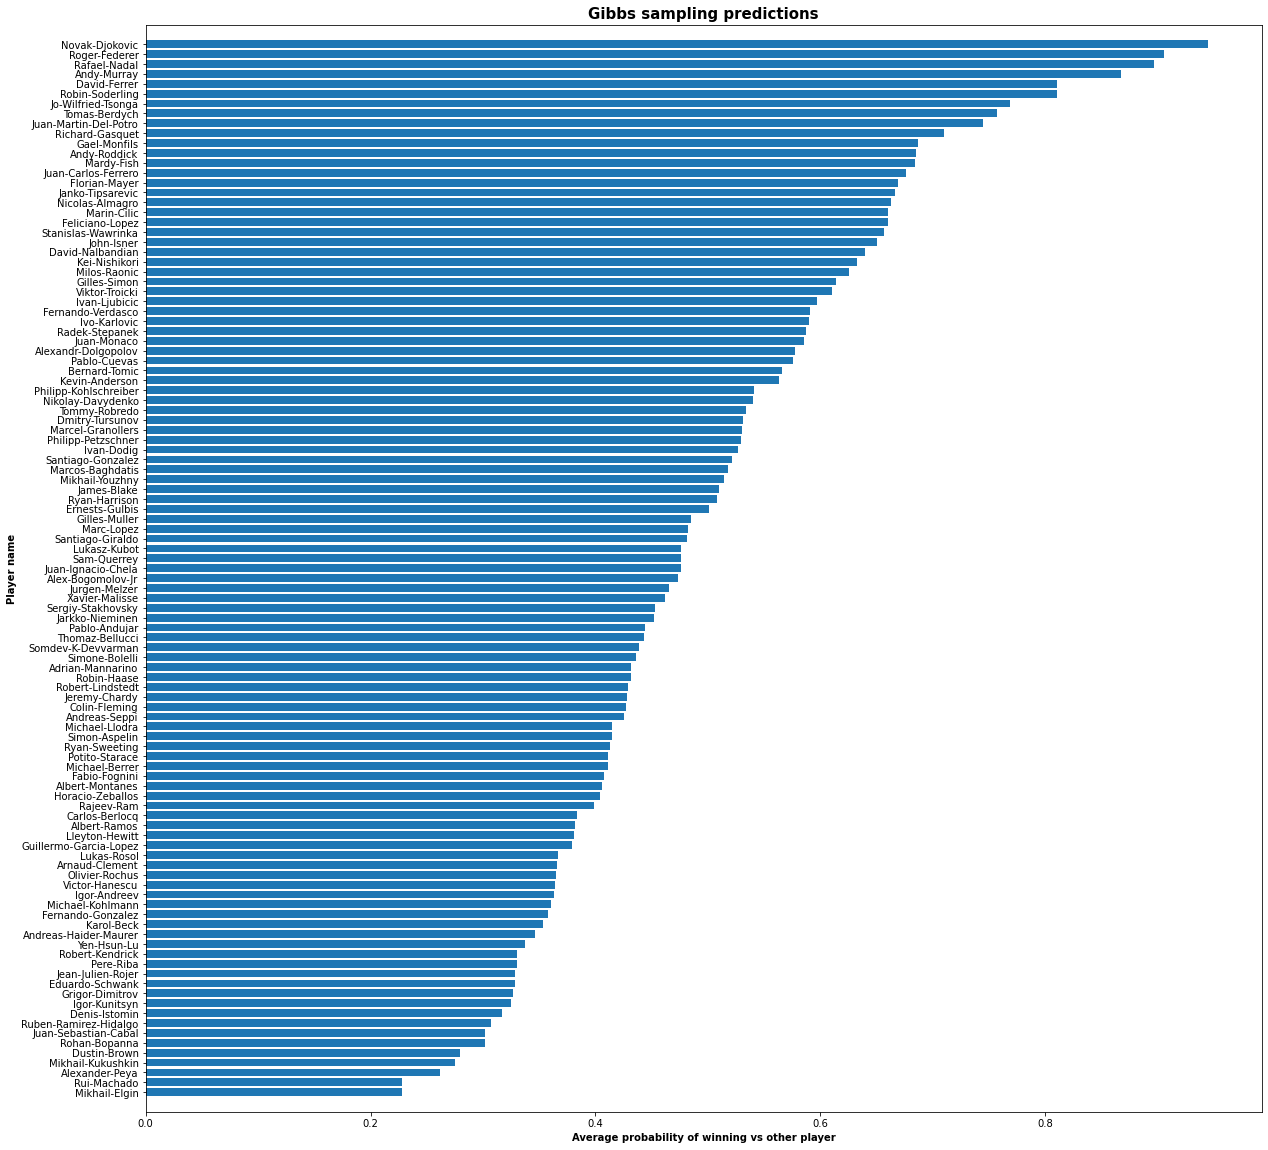

In [89]:
sorted_barplot(GS_predictions, W,
               title="Gibbs sampling predictions",
               xlabel="Average probability of winning vs other player",
               ylabel="Player name")

#### e.3 Predictions based on message passing algorithm

In [44]:
MP_predictions = np.zeros(M)

for i in range(M):
    avg_prob = 0
    for j in range(M):
        if i != j:
            mu = mean_player_skills[i] - mean_player_skills[j]
            var = 1.0 + 1/precision_player_skills[i] + 1/precision_player_skills[j]
            avg_prob += 1 - scipy.stats.norm.cdf(0, mu, np.sqrt(var))
    MP_predictions[i] = avg_prob/(M-1)

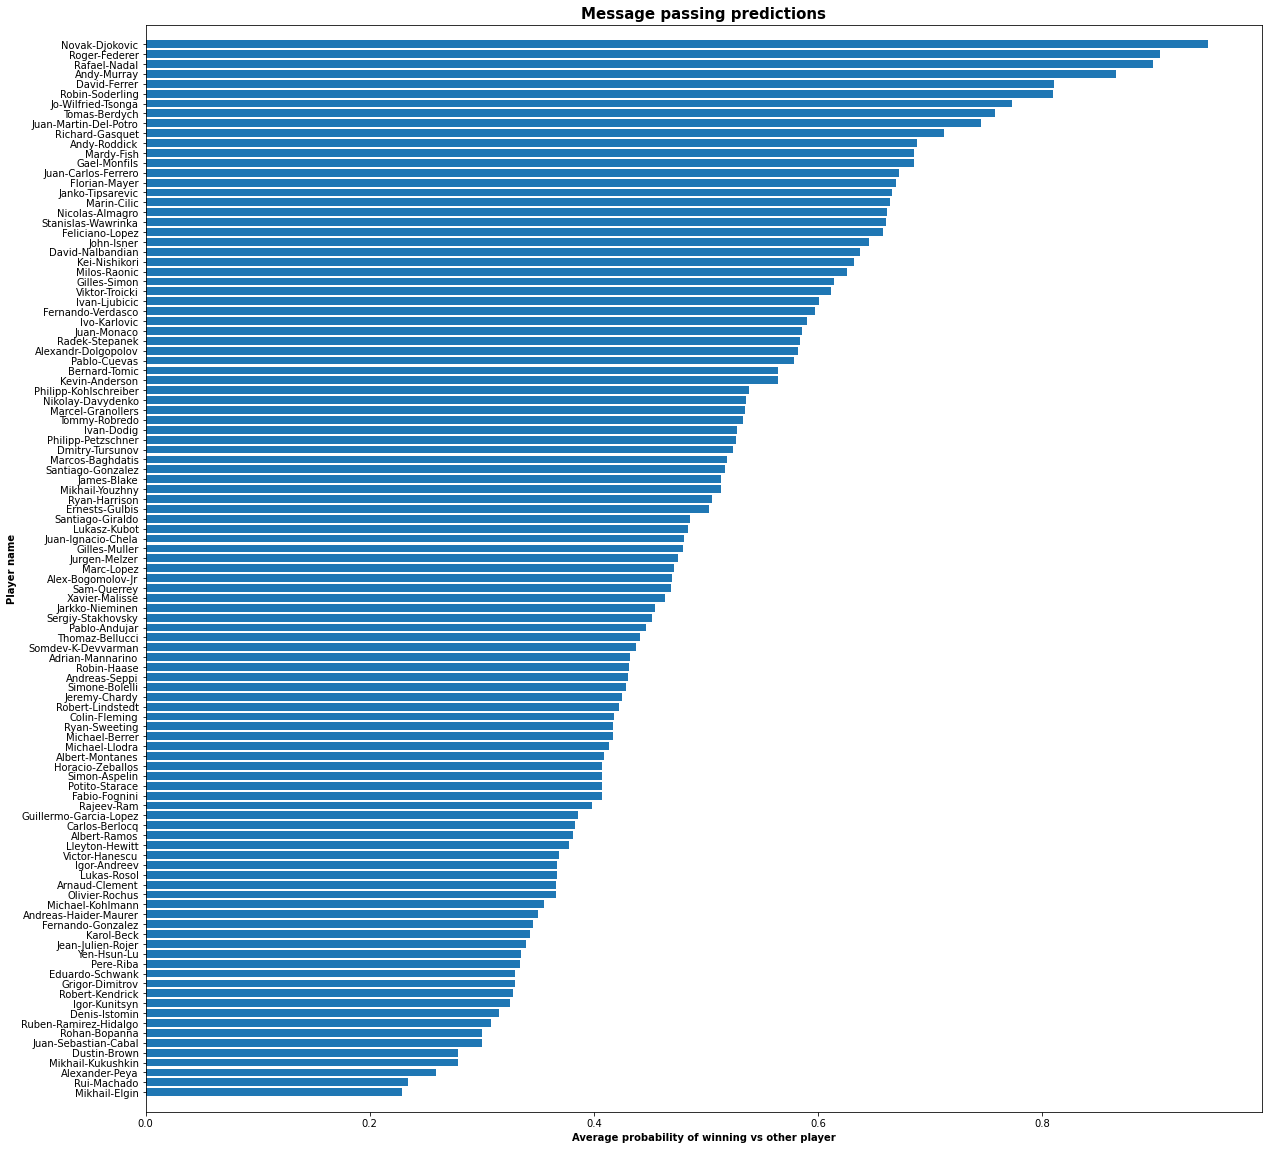

In [45]:
sorted_barplot(MP_predictions, W,
               title="Message passing predictions",
               xlabel="Average probability of winning vs other player",
               ylabel="Player name")

# TODO
- X Burn-in & Thinning
- Convergence plots
- D.2
- Writing report